In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
 
#import lightgbm as lgb
import catboost as catb

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('features.df')

In [3]:
df['Credit Default'].value_counts()

0    5105
1    2034
Name: Credit Default, dtype: int64

In [4]:
df.columns

Index(['Maximum Open Credit', 'Current Loan Amount', 'Number of Open Accounts',
       'Monthly Debt', 'Annual Income', 'Credit Score', 'Years in current job',
       'Home Ownership', 'Term', 'Years of Credit History', 'Purpose_0',
       'Purpose_1', 'Purpose_2', 'tax_problems_0', 'tax_problems_1',
       'tax_problems_2', 'Current Loan Max', 'Credit Score Max',
       'Credit Default'],
      dtype='object')

In [5]:
#df = df.drop('tax_problems', axis=1)
df.describe()

,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_0,Purpose_1,Purpose_2,tax_problems_0,tax_problems_1,tax_problems_2,Current Loan Max,Credit Score Max,Credit Default
count,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000
mean,76.169670,252.838386,3.099173,155.317899,12.712584,721.273175,0.950693,0.476537,0.258299,0.679367,0.977168,0.018910,0.003922,0.006724,0.979829,0.013447,0.114722,0.053789,0.284914
std,12.898221,54.498898,0.626737,43.572186,0.390639,24.651753,0.216523,0.499484,0.437730,0.466753,0.149379,0.136218,0.062508,0.081727,0.140594,0.115188,0.318708,0.225617,0.451405
min,24.203851,99.501000,1.226202,9.576656,11.071775,585.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.325454,217.706331,2.747838,126.784729,12.465403,712.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,76.039566,251.165905,3.063028,155.310890,12.706314,728.593526,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,84.983117,289.285611,3.458633,184.245408,12.959821,738.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,110.311751,374.341857,4.966237,287.023393,14.468758,751.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df['Credit Score'].max()

751.0

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print(f'TRAIN\n\n{classification_report(y_train_true, y_train_pred)}')
    print(f'TEST\n\n{classification_report(y_test_true, y_test_pred)}')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    for i in range(disbalance_coeff):
        sample = df.loc[df[target_name]==minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1)

In [9]:
TARGET_NAME = 'Credit Default'
NUM_FEATURES = ['Maximum Open Credit', 'Current Loan Amount', 'Annual Income', 'Number of Open Accounts',
                'Monthly Debt', 'Credit Score']
FEATURE_NAMES = df.columns.drop(TARGET_NAME)
FEATURE_NAMES = ['Maximum Open Credit', 'Current Loan Amount', 'Number of Open Accounts',
       'Monthly Debt', 'Annual Income', 'Credit Score', 'Years in current job',
       'Home Ownership', 'Term', 'Years of Credit History',
       'Purpose_1', 'Purpose_2', 'tax_problems_0', 'Credit Score Max', 'Current Loan Max']
CAT_FEATURES = set(FEATURE_NAMES).difference(NUM_FEATURES)

In [10]:
X = df[FEATURE_NAMES]
y = df[TARGET_NAME]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=.25, random_state=42)

In [12]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balancing = balance_df_by_target(df_for_balancing, TARGET_NAME)
df_balancing[TARGET_NAME].value_counts()

0    3840
1    3028
Name: Credit Default, dtype: int64

In [13]:
X_train = df_balancing.drop(columns=TARGET_NAME)
y_train = df_balancing[TARGET_NAME]

In [14]:
scaler = StandardScaler()
X_train[NUM_FEATURES] = scaler.fit_transform(X_train[NUM_FEATURES])

,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_1,Purpose_2,tax_problems_0,Credit Score Max,Current Loan Max
1574,1.639938,-0.050285,0.746669,-0.563258,0.841792,1.070325,1,1,0,0,0,0,0,0,1
4594,-1.047646,-1.096510,-0.308308,-0.559274,-1.944714,0.950846,0,0,0,0,0,0,0,0,0
670,0.006132,-0.032647,-0.308308,0.099976,-0.389084,-2.115777,1,0,1,1,0,0,0,0,0
2239,2.318360,0.343296,1.089676,0.109958,-0.366008,0.433105,1,1,0,1,0,0,0,1,0
4099,-0.524763,-0.671086,0.364703,-0.665987,-1.166038,-0.204116,1,0,0,1,0,0,0,0,0


In [16]:
X_train.describe()

,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_1,Purpose_2,tax_problems_0,Credit Score Max,Current Loan Max
count,6.868000e+03,6.868000e+03,6.868000e+03,6.868000e+03,6.868000e+03,6.868000e+03,6868.000000,6868.000000,6868.000000,6868.000000,6868.000000,6868.000000,6868.000000,6868.000000,6868.000000
mean,3.729625e-16,7.035077e-17,-5.069393e-17,8.380018e-16,8.385191e-16,8.736944e-16,0.946855,0.463891,0.278247,0.682149,0.019656,0.003786,0.007717,0.082411,0.089400
std,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,0.224339,0.498731,0.448168,0.465675,0.138827,0.061416,0.087513,0.275010,0.285341
min,-3.989085e+00,-2.794470e+00,-2.988300e+00,-3.376884e+00,-4.065611e+00,-5.381531e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.820537e-01,-6.581335e-01,-5.689618e-01,-6.561843e-01,-6.273363e-01,-3.657988e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-7.112449e-03,-5.028496e-02,-6.782320e-02,7.413631e-03,-1.031919e-02,3.136258e-01,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.878384e-01,6.808442e-01,7.466692e-01,6.592508e-01,6.332932e-01,6.662266e-01,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.666360e+00,2.178428e+00,2.958199e+00,3.024430e+00,4.564875e+00,1.229630e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
with open('model_scaler', 'wb') as f:
    pickle.dump(scaler, f)

In [18]:
NUM_FEATURES

['Maximum Open Credit',
 'Current Loan Amount',
 'Annual Income',
 'Number of Open Accounts',
 'Monthly Debt',
 'Credit Score']

In [19]:
X_test[NUM_FEATURES] = scaler.transform(X_test[NUM_FEATURES])
X_test.describe()

<ipython-input-19-f97d8e40563f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[NUM_FEATURES] = scaler.transform(X_test[NUM_FEATURES])
/Users/kosmosivanov/git-repo/Python_DS_more/virt_env/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_1,Purpose_2,tax_problems_0,Credit Score Max,Current Loan Max
count,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000
mean,0.040546,-0.015007,-0.008906,-0.030522,0.025968,0.047005,0.951261,0.481232,0.280672,0.676190,0.021289,0.003361,0.006723,0.056583,0.114846
std,0.985214,0.992706,0.983659,1.002466,1.016643,0.984959,0.215383,0.499788,0.449454,0.468059,0.144385,0.057896,0.081739,0.231108,0.318925
min,-3.771521,-2.789676,-2.988300,-3.027761,-4.210306,-5.262052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.645855,-0.651884,-0.568962,-0.687819,-0.613908,-0.363421,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.028783,-0.050285,-0.067823,-0.048921,0.013301,0.353452,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.705841,0.656255,0.561172,0.626276,0.683421,0.711889,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.663225,2.173810,2.958199,2.998180,3.980232,1.229630,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      3840
           1       0.70      0.52      0.60      3028

    accuracy                           0.69      6868
   macro avg       0.69      0.67      0.67      6868
weighted avg       0.69      0.69      0.68      6868

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1265
           1       0.57      0.57      0.57       520

    accuracy                           0.75      1785
   macro avg       0.69      0.69      0.69      1785
weighted avg       0.75      0.75      0.75      1785

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1039  226
1                226  294


In [52]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      3840
           1       0.79      0.72      0.76      3028

    accuracy                           0.79      6868
   macro avg       0.79      0.79      0.79      6868
weighted avg       0.79      0.79      0.79      6868

TEST

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1265
           1       0.48      0.53      0.50       520

    accuracy                           0.69      1785
   macro avg       0.64      0.64      0.64      1785
weighted avg       0.70      0.69      0.70      1785

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               966  299
1               247  273


In [53]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)
model_catb.fit(X_train, y_train)
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3840
           1       0.91      0.81      0.86      3028

    accuracy                           0.88      6868
   macro avg       0.89      0.88      0.88      6868
weighted avg       0.89      0.88      0.88      6868

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1265
           1       0.54      0.51      0.53       520

    accuracy                           0.73      1785
   macro avg       0.67      0.67      0.67      1785
weighted avg       0.73      0.73      0.73      1785

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1038  227
1                254  266


In [20]:
model_catb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'border_count': 254,
 'classes_count': 0,
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.02345599979162216,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 10,
 'bootstrap_type': 'MVS',
 'max_leaves': 64}

In [21]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)

In [22]:
from catboost import cv
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 300
params['custom_loss'] = 'F1'
params['random_seed'] = 42
params['learning_rate'] = 0.05

cv_date = cv(
    params=params, 
    pool=catb.Pool(data=df[FEATURE_NAMES], label=df[TARGET_NAME], cat_features=CAT_FEATURES),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False
    ,
    verbose=False
    
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [20]:
final_model = catb.CatBoostClassifier(iterations=201, custom_loss=['AUC','Accuracy', 'F1'], 
                                      l2_leaf_reg=3, leaf_estimation_method='Newton',
                                      learning_rate=0.05, silent=True, random_state=42,)

In [24]:
final_model.fit(X_train, y_train, cat_features=CAT_FEATURES,
                eval_set=(X_test, y_test),
                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
final_model.best_iteration_

198

In [26]:
#X_train = df_balancing[FEATURE_NAMES]
#y_train = df_balancing[TARGET_NAME]

In [21]:
final_model.fit(X_train, y_train)
print(final_model.get_params())
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

{'iterations': 201, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'leaf_estimation_method': 'Newton', 'silent': True, 'custom_loss': ['AUC', 'Accuracy', 'F1'], 'random_state': 42}
TRAIN

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      3840
           1       0.81      0.67      0.74      3028

    accuracy                           0.79      6868
   macro avg       0.79      0.78      0.78      6868
weighted avg       0.79      0.79      0.78      6868

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1265
           1       0.55      0.55      0.55       520

    accuracy                           0.74      1785
   macro avg       0.68      0.68      0.68      1785
weighted avg       0.74      0.74      0.74      1785

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1035  230
1                236  284


In [22]:
with open('model_class.bin', 'wb') as f:
    pickle.dump(final_model, f)

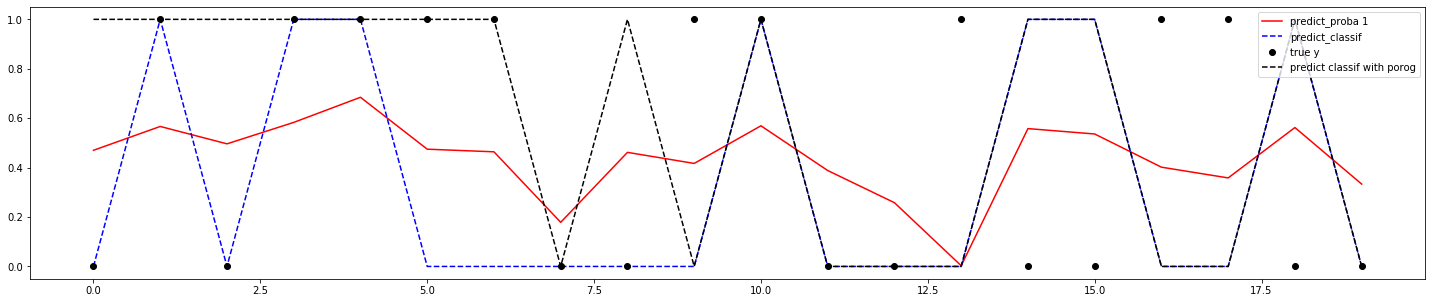

In [23]:
plt.figure(figsize=(25, 5))
plt.plot(y_test_pred_probs[:20, 1], 'r', label='predict_proba 1')
#plt.plot(y_test_pred_probs[:20, 0], 'g', label='predict_proba 0')
plt.plot(y_test_pred[:20], '--b', label='predict_classif')
plt.plot(y_train.iloc[:20].values, 'ok', label='true y')

y_p = np.array(y_test_pred_probs[:,1]>0.43).astype('int')
plt.plot(y_p[:20], '--k', label='predict classif with porog')
plt.legend()
plt.show()

In [58]:
y_test_pred_probs

array([[0.55248747, 0.44751253],
       [0.44001524, 0.55998476],
       [0.54431677, 0.45568323],
       ...,
       [0.40331996, 0.59668004],
       [0.5205547 , 0.4794453 ],
       [0.52278734, 0.47721266]])

In [59]:
pd.concat((X_train[:20], y_train[:20]), axis=1)

,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_1,Purpose_2,tax_problems_0,Credit Score Max,Current Loan Max,Credit Default
3551,0.408542,0.940984,-0.308308,-0.172808,0.160153,-0.212396,1,0,1,1,0,0,0,0,0,0
4807,-0.724640,-0.645356,-0.854031,-0.457566,-0.641297,0.047835,1,0,0,1,0,0,0,0,0,0
829,-1.672826,0.098786,-0.854031,0.051130,-0.132487,-0.199424,1,0,0,0,0,0,0,0,0,1
1553,-0.386044,-0.138839,0.364703,-0.435233,-0.219084,0.046829,1,1,0,1,0,0,0,0,0,1
6834,-3.032517,-0.438576,-0.067823,-0.614511,-0.978176,-1.681969,1,0,0,1,0,0,0,0,0,1
2395,-0.557243,-0.370957,-1.523190,-0.472287,-0.614115,0.053797,1,0,0,0,0,0,0,0,0,1
6195,0.597135,1.168535,0.364703,0.581435,0.125027,0.257014,1,1,1,1,0,0,0,1,0,1
233,-0.727998,0.077835,0.364703,0.589241,0.779848,0.010885,1,1,0,1,0,0,0,0,0,0
5474,-0.181061,-0.509794,0.746669,-0.584407,-1.738028,0.673898,1,1,0,0,0,0,0,0,0,1
5232,0.744609,0.846299,-1.169337,0.117783,-0.700064,1.155422,1,0,0,1,0,0,0,0,0,0


In [32]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

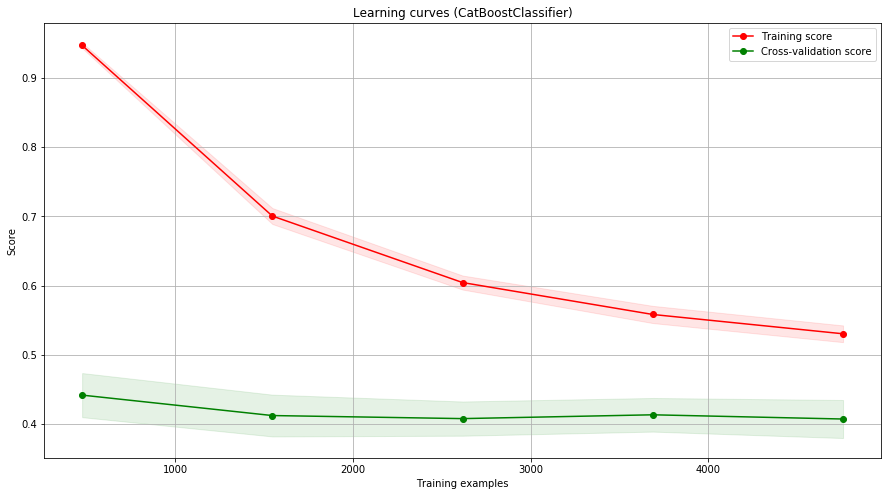

In [33]:
show_learning_curve_plot(final_model, X, y)

In [28]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.4, 0.55, 25):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

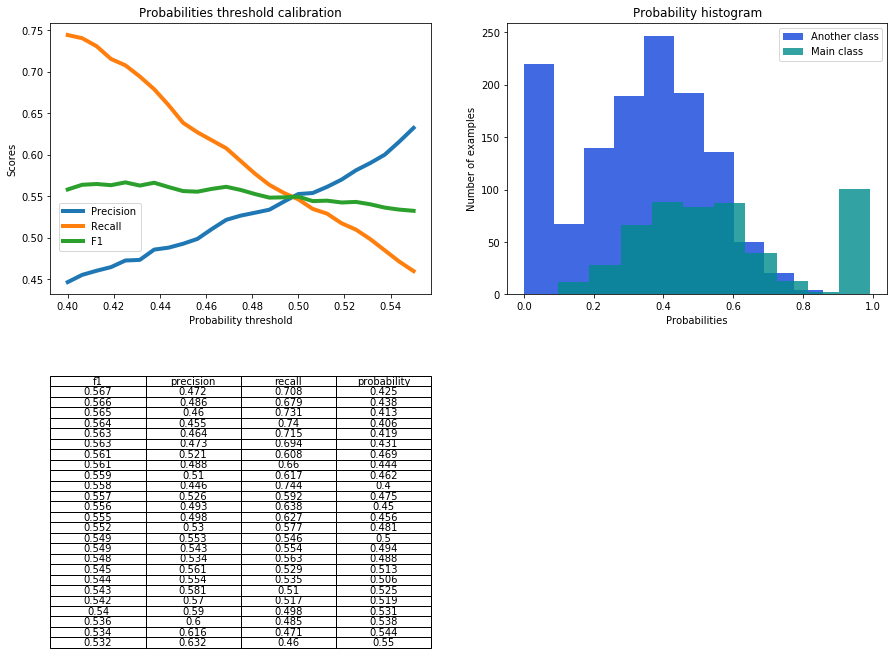

In [29]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [62]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

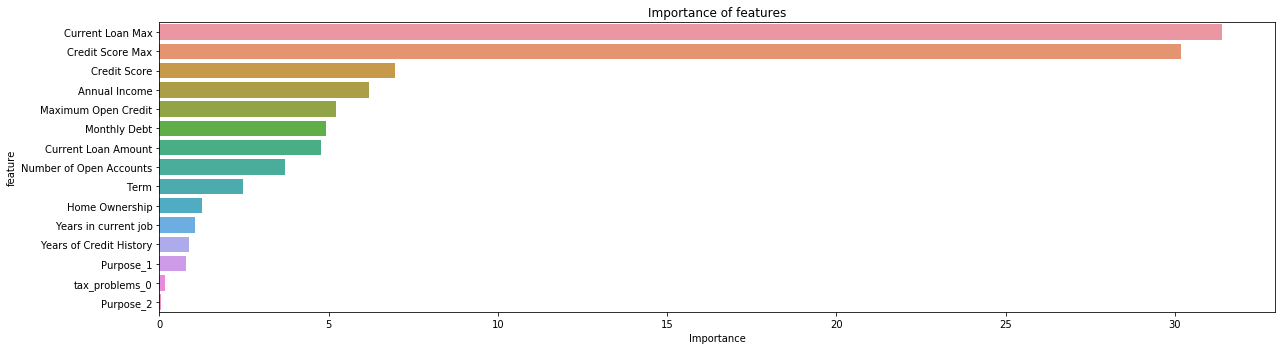

In [63]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [64]:
y_test.value_counts()

0    1265
1     520
Name: Credit Default, dtype: int64

In [65]:
len(y_test_pred[y_test_pred == 1])

507

In [66]:
X_train['Maximum Open Credit'].min(), X_train['Maximum Open Credit'].max()

(-3.989084686077085, 2.666359519423064)

In [25]:
X_test[CAT_FEATURES].describe()

,Current Loan Max,Purpose_1,Credit Score Max,Home Ownership,Term,tax_problems_0,Purpose_2,Years in current job,Years of Credit History
count,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000
mean,0.114846,0.021289,0.056583,0.481232,0.280672,0.006723,0.003361,0.951261,0.676190
std,0.318925,0.144385,0.231108,0.499788,0.449454,0.081739,0.057896,0.215383,0.468059
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
FEATURE_NAMES

['Maximum Open Credit',
 'Current Loan Amount',
 'Number of Open Accounts',
 'Monthly Debt',
 'Annual Income',
 'Credit Score',
 'Years in current job',
 'Home Ownership',
 'Term',
 'Years of Credit History',
 'Purpose_1',
 'Purpose_2',
 'tax_problems_0',
 'Credit Score Max',
 'Current Loan Max']